In [135]:
from __future__ import print_function
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import cdist
import math
import pylab as pl
import csv
import datetime

In [2]:
words,defs = pickle.load(open("train_data_filtered.pkl", "rb" ),encoding='latin1')
word_embs = pickle.load(open("../embeddings/D_cbow_pdw_8B.pkl", "rb" ),encoding='latin1')
#Based on https://stackoverflow.com/questions/32957708/python-pickle-error-unicodedecodeerror

In [136]:
#Selecting subset of data
training_words = words[:1000]
training_defs = defs[:1000]

In [137]:
#Create vocab
def create_vocab(words,defs):
    x_vocab = {}
    y_vocab = {}
    x_idx = 0
    y_idx = 0
    for word in words:
        if word not in y_vocab:
            y_vocab[word] = y_idx
            y_idx += 1

    for word_def in defs:
        for word in word_def:
            if word not in x_vocab:
                x_vocab[word] = x_idx
                x_idx += 1
    x_vocab['<pad>'] = x_idx #Pad token is last index useed for masking
    y_vocab['<pad>'] = y_idx #Pad token is last index useed for masking
    print('Unique words found in x_vocab ',len(x_vocab))
    print('Unique words found in y_vocab ',len(y_vocab))
    return x_vocab,y_vocab

In [138]:
X_vocab,Y_vocab = create_vocab(training_words,training_defs)

Unique words found in x_vocab  2739
Unique words found in y_vocab  75


In [139]:
#Hyper params definition (from paper)
vocab_len = len(X_vocab)
max_len = 16 #Number of timesteps
input_emb_dim = 500 #Dimension of learned input embeddings
output_emb_dim = 500 #Standard dim of output provided
lstm_units = 512
batch_size = 16
epochs = 10
train_val_split = 0.95 #95% train, 5% validation
MODEL_PATH = "rlModelState.tar"

In [140]:
training_x = [[X_vocab[word] for word in word_def] for word_def in training_defs]
training_y = [Y_vocab[word] for word in training_words]
#Pad sequences, prepare training data
X = np.ones((len(training_x), max_len)) * 0
for i in range(len(training_x)):
    seq = training_x[i]
    seq_len = min(len(seq),max_len)
    X[i,0:seq_len] = seq[0:seq_len]
Y = np.array(training_y)
data_set = []
for i in range(len(training_x)):
    data_set.append((X[i],Y[i]))

In [141]:
#Split dataset into training and validation set
np.random.shuffle(data_set)
val_idx = math.floor(train_val_split*len(data_set))
print(val_idx)
train_set = data_set[:val_idx]
val_set = data_set[val_idx:]

950


In [142]:
class BatchIterator:

    """Iterator that returns batches of fixed sizes for specified epochs"""

    def __init__(self, data_set, batch_size, epochs):
        self.data_set = data_set
        self.start_idx = 0
        self.epochs = epochs
        self.batch_size = batch_size
        self.len_data_set = len(self.data_set)
        self.current_epoch = 1
        self.current_batch = 1       
        self.batches_per_epoch = math.ceil(self.len_data_set/self.batch_size)
        print(self.len_data_set)
        print(self.batches_per_epoch)
        np.random.shuffle(self.data_set)
    def has_ended(self):
        return self.current_epoch > self.epochs
    
    def __iter__(self):
        return self

    def __next__(self):
        #print('Current start index '+str(self.start_idx))
        #print('Current epoch, current batch '+str(self.current_epoch)+' , '+str(self.current_batch))
        batch = []
        i = self.start_idx
        end = min(self.len_data_set-1,i+self.batch_size-1)
        #print(end)
        while(i <= end):
            batch.append(self.data_set[i])
            i += 1
        #If can't find enough data points till the end of list, start from zero again
        if(len(batch) < self.batch_size):
            #print('Over shot the length of the list')
            i = 0
            while(len(batch) != self.batch_size):
                batch.append(self.data_set[i]) 
                i += 1
        self.start_idx = i
        
        #Increment epoch, reset variables, reshuffle the dataset
        if(self.current_batch == self.batches_per_epoch):
            self.current_epoch += 1            
            self.current_batch = 1
            #Shuffle the list, reset start idx
            np.random.shuffle(self.data_set)
            self.start_idx = 0
        else:
            self.current_batch += 1
        return batch

In [143]:
#Create embedding matrix
embedding_matrix = np.zeros((vocab_len, output_emb_dim))
for word, i in X_vocab.items():
    embedding_vector = word_embs.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        print('Embedding not found')
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(output_emb_dim, ))
print("Embedding matrix created!")

Embedding not found
Embedding matrix created!


In [144]:
class PolicyEstimator(nn.Module):

    def __init__(self, weight_matrix, embedding_dim, hidden_dim, vocab_size, tagset_size, seq_len, batch_size):
        super(PolicyEstimator, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.tagset_size = tagset_size
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        #self.word_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        #Load pretrained word embeddings
        self.word_embeddings = nn.Embedding.from_pretrained(weight_matrix)
        #Trainable false
        self.word_embeddings.weight.requires_grad = False
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.batch_size, self.hidden_dim),
                torch.zeros(1, self.batch_size, self.hidden_dim))
    
    def predict(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        X = lstm_out.contiguous()
        X = X.view(-1, X.shape[2])
        tag_space = self.hidden2tag(X)
        tag_scores = F.softmax(tag_space, dim=1) #Return softmax here!
        Y_hat = tag_scores.view(self.batch_size, self.seq_len, self.tagset_size)
        return Y_hat

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        X = lstm_out.contiguous()
        X = X.view(-1, X.shape[2])
        tag_space = self.hidden2tag(X)
        tag_scores = F.log_softmax(tag_space, dim=1) #Return log softmax for forward function!
        Y_hat = tag_scores.view(self.batch_size, self.seq_len, self.tagset_size)
        return Y_hat

In [145]:
# points should have embeddings of all output words in a list
#Normalize output word embeddings to unit vectors
def normalize_vocab(voc):
    points = [None]*(len(voc))
    for w, idx in voc.items():
        points[idx] = embedding_matrix[idx]/np.linalg.norm(embedding_matrix[idx])
    points = np.array(points)
    return points

In [146]:
points = normalize_vocab(Y_vocab)

In [147]:
def get_pred_rank (pred_idx, label_idx, points):
    dist_list = cdist(points, np.array([points[pred_idx]]), 'cosine').flatten() #Convert 2d into 1d array
    #result_indices = np.argpartition(dist_list, k)[:k]
    #if label_idx in result_indices:
    #    return True
    #return False
    result_indices = list(np.argsort(dist_list))
    return result_indices.index(label_idx)

In [148]:
def get_reward_for_action(action,target):
    #Using inverse rank as reward
    rank = get_pred_rank(action, target, points) + 1
    return 1/rank

In [149]:
def validate():
    '''
    (val_set) => (acc, top10, top100)
    form chunks of batch size
    get predictions for each time step from the LSTM
    consider output of last time step as pred of LSTM
    call rank function get rank, calculate acc
    '''
    val_results = []
    count_10 = 0
    count_100 = 0
    i = 0
    while i < len(val_set) and len(val_set) > len(val_results):       
        val_batch = []
        val_batch = val_set[i:i+batch_size]
        term_idx = batch_size
        if(len(val_batch) < batch_size):
            term_idx = len(val_batch)
            val_batch += val_set[0:batch_size-len(val_batch)]
        val_states = [sequence[0] for sequence in val_batch]
        val_tensor = torch.tensor(val_states, dtype=torch.long)    
        val_out = model.predict(val_tensor)
        val_out = val_out.detach().numpy()
        i += batch_size
        #print(val_out.shape)
        for j in range(batch_size):
            if(j < term_idx):
                val_target = val_batch[j][1]
                #print(val_out[i])
                #print('=====')
                #print(val_out[i][batch_size-1])
                val_pred = np.argmax(val_out[j][batch_size-1])
                #print(val_target,val_pred)
                rank = get_pred_rank(val_pred, val_target, points)
                if(rank < 10):
                    count_10 += 1
                if(rank < 100):
                    count_100 += 1
                #print(rank)
                val_results.append(rank)
    #print('Iter done')
    #print(len(val_results),len(val_set))
    return {'t_10':count_10,'t_100':count_100,'l':len(val_results)}

In [163]:
def train(policy_estimator, data_iterator):
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.parameters(),lr=0.01)
    total_rewards = []
    counter = 0
    loss_freq = 10 #Print loss every 10 batches   
    losses=[]
    last_epoch = 1
    last_epoch_loss = 1000
    
    while(not data_iterator.has_ended()):
        policy_estimator.hidden = policy_estimator.init_hidden()
        action_space = np.arange(policy_estimator.tagset_size)
        
        #Get next batch
        batch_data = next(data_iterator)
        counter += 1
        batch_rewards = []
        batch_actions = []
        batch_states = [sequence[0] for sequence in batch_data]
        state_tensor = torch.tensor(batch_states, dtype=torch.long)
        
        batch_out = policy_estimator.predict(state_tensor)
        
        batch_out = batch_out.detach().numpy()
        for i in range(len(batch_data)):
            #Iterate over each LSTM time step
            actions = []
            rewards = []
            target = batch_data[i][1] #Get label of the current sequence
            for j in range(batch_out[i].shape[0]):
                action_probs = batch_out[i][j]
                action = np.random.choice(action_space, p=action_probs)
                actions.append([action]) #To have 1 dimension at the end for indexing
                reward = get_reward_for_action(action,target)
                rewards.append(reward)                   
            batch_actions.append(actions)
            batch_rewards.append(np.mean(rewards)) #Append average reward per time step to batch_rewards                   
        total_rewards.append(sum(batch_rewards)) #Total of rewards for a batch
        reward_tensor = torch.FloatTensor(batch_rewards)
        
        action_tensor = torch.LongTensor(batch_actions)

        #Gradient update
        optimizer.zero_grad()

        # Calculate loss
        logprob = policy_estimator(state_tensor)
        
        '''
        Dimensionality check
        logprob = batch_size * max_len * tagset_size(output_vocab_dim)
        reward_tensor = batch_size * max_len
        action_tensor = batch_size * max_len * 1 (3d tensor so that I can do the gather operation)
        '''
        
        selected_logprobs = torch.gather(logprob,2,action_tensor)
        #Reshape so that dot product can be computed
        selected_logprobs = selected_logprobs.view(selected_logprobs.shape[0],selected_logprobs.shape[1])
        selected_logprobs = reward_tensor * selected_logprobs
        
        loss = -selected_logprobs.mean(1).sum() #Take mean of timestep for loss per seq, sum for all seq in batch
        
        losses.append(loss.item())
        if(counter % loss_freq == 0):
            val_results = validate()
            rl_loss = round(loss.item(),4)
            print("\rEpoch : {}, Batch count: {} Current Loss: {:.4f} Top 10 acc: {:.2f} Top 100 acc: {:.2f}".format(
                data_iterator.current_epoch, counter, rl_loss, 
                val_results['t_10']/val_results['l'],
                val_results['t_100']/val_results['l']))
            
            #Write these results to the csv log file            
            log_writer.writerow([data_iterator.current_epoch, counter, rl_loss, 
                                 val_results['t_10']/val_results['l'],
                                 val_results['t_100']/val_results['l']])
        
        if(last_epoch != data_iterator.current_epoch):
            #Save the model if loss has decreased
            prev_loss = last_epoch_loss
            if(prev_loss > loss.item()):
                print("Loss improved from {:.4f} to {:.4f}".format(
                    prev_loss, loss.item()
                ))
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, MODEL_PATH)
                print("Last checkpoint at "+str(datetime.datetime.now()))
            last_epoch = data_iterator.current_epoch
            last_epoch_loss = loss.item()

        # Calculate gradients
        loss.backward()

        # Apply gradients
        optimizer.step()
    return losses

In [164]:
# Initialize weight matrix tensor from embedding matrix
weight_matrix = torch.FloatTensor(embedding_matrix)

In [165]:
# Initialize dataIterator
batchIterator = BatchIterator(train_set, batch_size, 4)

950
60


In [166]:
# Initialize model
model = PolicyEstimator(weight_matrix, input_emb_dim, lstm_units, len(X_vocab), len(Y_vocab), max_len, batch_size)

In [167]:
csv_log_file = open('training_log.csv', mode='w')
log_writer = csv.writer(csv_log_file)
output_losses = train(model, batchIterator)
csv_log_file.close()

Epoch : 1, Batch count: 10 Current Loss: 1.8532 Top 10 acc: 0.12 Top 100 acc: 1.00
Epoch : 1, Batch count: 20 Current Loss: 1.6027 Top 10 acc: 0.34 Top 100 acc: 1.00
Epoch : 1, Batch count: 30 Current Loss: 2.0933 Top 10 acc: 0.24 Top 100 acc: 1.00
Epoch : 1, Batch count: 40 Current Loss: 0.6872 Top 10 acc: 0.02 Top 100 acc: 1.00
Epoch : 1, Batch count: 50 Current Loss: 0.6793 Top 10 acc: 0.02 Top 100 acc: 1.00
Epoch : 2, Batch count: 60 Current Loss: 1.4335 Top 10 acc: 0.02 Top 100 acc: 1.00
Epoch : 2, Batch count: 70 Current Loss: 1.3952 Top 10 acc: 0.04 Top 100 acc: 1.00
Epoch : 2, Batch count: 80 Current Loss: 1.4837 Top 10 acc: 0.02 Top 100 acc: 1.00
Epoch : 2, Batch count: 90 Current Loss: 1.1314 Top 10 acc: 0.10 Top 100 acc: 1.00
Epoch : 2, Batch count: 100 Current Loss: 1.6151 Top 10 acc: 0.14 Top 100 acc: 1.00
Epoch : 2, Batch count: 110 Current Loss: 2.2269 Top 10 acc: 0.12 Top 100 acc: 1.00
Epoch : 3, Batch count: 120 Current Loss: 1.5806 Top 10 acc: 0.18 Top 100 acc: 1.00
E

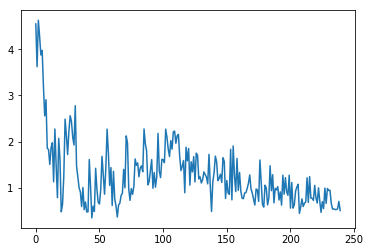

In [168]:
#Plot output losses
pl.plot(output_losses)

In [162]:
'''
#Eval sub-routine

model = PolicyEstimator(weight_matrix, input_emb_dim, lstm_units, len(X_vocab), len(Y_vocab), max_len, batch_size)
optimizer = optim.Adam(model.parameters(),lr=0.01)

checkpoint = torch.load(MODEL_PATH)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
validate()

'''

"\n#Eval sub-routine\n\nmodel = PolicyEstimator(weight_matrix, input_emb_dim, lstm_units, len(X_vocab), len(Y_vocab), max_len, batch_size)\noptimizer = optim.Adam(model.parameters(),lr=0.01)\n\ncheckpoint = torch.load(MODEL_PATH)\n\nmodel.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\n\nmodel.eval()\nvalidate()\n\n"